In [2]:
%matplotlib inline
# import pyedflib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras import layers
from keras.layers import Dense, RepeatVector, TimeDistributed
from keras.layers import LSTM, SimpleRNN, Conv1D, MaxPooling1D
from keras import backend as K 


import os

# from google.colab import drive
# drive.mount('/content/drive')
nb_dir='drive/My Drive/Colab Notebooks/'
# import sys
# sys.path.append(nb_dir)

Using TensorFlow backend.


In [22]:
dirAn=nb_dir+"dataAn/"
names = ['lily','jaya','angela','pat','hajime','yanan','elena']
activities = ['read','copy','write','null','video','browse']
DURATION=5000

def fugure_out_who_and_what(filenm):
  if filenm.endswith(".txt") :
    name = None
    for nm in names:
      if nm in filenm.lower():
        name = nm
        break
    if 'êlena' in filenm or 'êlena' in filenm:
      name = 'elena'
    
    activ = None
    for ac in activities:
      if ac in filenm.lower():
        activ = ac
        break
    if 'rest' in filenm.lower():
      activ = 'null'
    if 'watch' in filenm.lower():
      activ = 'video'
    
  else: return None
  if name is None or activ is None: return None
  
  return (name,activ)
  
  
def one_file_chopping(filenm,select='A1', duration=DURATION, burnin=50000,
                      sample_step=1000 , scale  = False):
    with open(filenm) as f:
        buffer = f.readlines()

    for i,line in enumerate(buffer):
        if  '# EndOfHeader\n' in line:
            break
#     header = buffer[:i+1]
    data = buffer[i+1:]
    dataset = []

    sel = ["nSeq", "I1", "I2", "O1", "O2", "A1", "A4"].index (select) 
        
    for line in data:
      dataset.append( int(line.split('\t')[sel]) )
    
#     print(dataset)
    
    lenn = len(dataset)
    
    new_chunk =[]

    start = burnin
    
    while start + duration  < lenn:
      new_chunk.append( [[i] for i in dataset[start:start + duration ] ])
      start+=np.random.randint(sample_step,sample_step+1000)

#         linedata = [ int(x) for x in line.split('\t')[:-1] ]

    return new_chunk
  
# fugure_out_who_and_what('angnulllcopyeareadangenullla-pat.txt')
# print(len(one_file_chopping(dirAn+'opensignals_001403173836_2019-03-25_15-57-5-hajime-read1.txt')))

In [23]:
X = []
whowhat = []
for file in os.listdir(dirAn):
  ww = fugure_out_who_and_what(dirAn+ file)
  if ww is None: 
    print(file,'is useless')
    continue
  newchunk = one_file_chopping(dirAn+ file)
  X.extend(newchunk)
  whowhat.extend([[ww[0],ww[1]]]*len(newchunk))
    
labeldf = pd.DataFrame(whowhat,columns=['name','activity'])



opensignals_001403173836_2019-03-24_19-30-11-angela-eyemoves.txt is useless
opensignals_001403173836_2019-03-24_12-41-17-Yanan-eye-moves.txt is useless
opensignals_001403173836_2019-03-24_13-55-52-NULL-1.txt is useless
opensignals_001403173836_2019-03-24_15-23-27.txt is useless
opensignals_001403173836_2019-03-24_14-40-37-elena-eyemoves.txt is useless
opensignals_001403173836_2019-03-24_16-36-46-lily-eyemoves.txt is useless
opensignals_001403173836_2019-03-25_17-13-15-hajime-eye-moves.txt is useless
opensignals_001403173836_2019-03-25_10-34-54-jaya-eyemoves.txt is useless


In [24]:
len(X),len(X[0])

(13565, 5000)

In [25]:
newx = np.ndarray((len(X),len(X[0]),1))
for i in range(len(X)):
  a = scale(X[i])
  for j in range(len(X[0])):
    newx[i,j,0] = a[j][0]

In [26]:
# # scale(X1,axis =1)
# cnt = 0
# newx =[]
# for x in X:
#   newx.append(scale(x))
#   cnt = 0
newx[0], len(newx), len(newx[0]),len(newx[0][0])

(array([[-0.40679019],
        [ 0.60176604],
        [-0.95491858],
        ...,
        [-1.34957101],
        [-0.20946397],
        [-0.27523938]]), 13565, 5000, 1)

In [27]:
np.save(nb_dir+'20000tt5000len1000overlap.npz',newx)

In [0]:
X = None 

In [28]:
X_train, X_test, y_train, y_test = train_test_split( newx,  pd.get_dummies(labeldf.activity) ,
      test_size=0.1, random_state=0 ,stratify = pd.get_dummies(labeldf.activity) )

In [29]:
len(X_train), len(X_test), X_train[0], y_train.iloc[0]

(12208, 1357, array([[-0.49799835],
        [ 0.0702983 ],
        [ 0.0702983 ],
        ...,
        [-0.21385003],
        [ 0.92274327],
        [ 0.35444662]]), browse    0
 copy      0
 null      0
 read      0
 video     0
 write     1
 Name: 10349, dtype: uint8)

# CNN-LSTM model

In [30]:
N_filters=32
# CNN  model
K.clear_session()
model=Sequential()
# encode
model.add(Conv1D(filters = N_filters,kernel_size=10,strides=5,input_shape=(DURATION,1)))
model.add(Conv1D(filters = N_filters,kernel_size=3))
model.add(MaxPooling1D(pool_size = 3))
model.add(Conv1D(filters = N_filters,kernel_size=3))
model.add(Conv1D(filters = N_filters,kernel_size=3))
model.add(MaxPooling1D(pool_size = 3))
# model.add(Conv1D(filters = N_filters,kernel_size=3))
# model.add(Conv1D(filters = N_filters,kernel_size=3))
# model.add(MaxPooling1D(pool_size = 3))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(len(activities),activation='softmax'))
# model.add(TimeDistributed(Dense(len(activities),activation='softmax')))
# distributing the identical dense layer to the RNNs

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 999, 32)           352       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 997, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 332, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 330, 32)           3104      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 328, 32)           3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 109, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 109, 32)           8320      
__________

In [31]:
BATCH_SIZE = 32

history =    model.fit(X_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=30,
              validation_data=(X_test, y_test))

Train on 12208 samples, validate on 1357 samples
Epoch 1/30
12208/12208 [==============================] - 133s 11ms/step - loss: 1.7319 - acc: 0.2542 - val_loss: 1.7305 - val_acc: 0.2085
Epoch 2/30
12208/12208 [==============================] - 131s 11ms/step - loss: 1.6958 - acc: 0.2707 - val_loss: 1.6700 - val_acc: 0.2852
Epoch 3/30
12208/12208 [==============================] - 131s 11ms/step - loss: 1.6420 - acc: 0.2933 - val_loss: 1.6523 - val_acc: 0.3021
Epoch 4/30
12208/12208 [==============================] - 130s 11ms/step - loss: 1.6474 - acc: 0.3029 - val_loss: 1.6499 - val_acc: 0.3058
Epoch 5/30
12208/12208 [==============================] - 131s 11ms/step - loss: 1.6109 - acc: 0.3272 - val_loss: 1.6344 - val_acc: 0.3066
Epoch 6/30
12208/12208 [==============================] - 130s 11ms/step - loss: 1.5993 - acc: 0.3298 - val_loss: 1.5976 - val_acc: 0.3522
Epoch 7/30
12208/12208 [==============================] - 131s 11ms/step - loss: 1.6125 - acc: 0.3284 - val_loss: 1.6

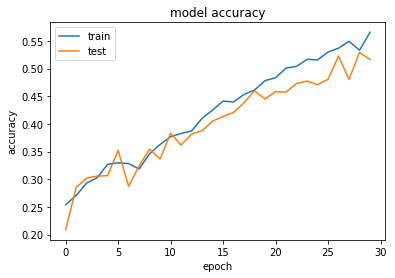

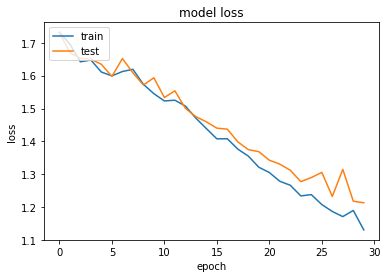

In [32]:
#history # summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
from keras.models import load_model
model.save('CCmCCmLLd30epochs.h5') 


In [107]:
# from importlib import reload
# import matplotlib . pyplot as plt
# plt = reload(plt)

In [ ]:
confusion_mat = np.zeros((6,6))
for i,xtest in enumerate(list(preds)): 
    y =  np.argmax(y_test.iloc[i].values) 
    confusion_mat[xtest,y]+=1  
preds = np.argmax(model.predict(X_test),axis = 1)

In [100]:
act2number={'browse':0,'copy':1,'null':2,'read':3,'video':4,'write':5}
number2act = {v:k for (k,v) in act2number.items()}
# pd.get_dummies(labeldf.activity[::1000])
ticks = [number2act[i] for i in range(6)]
ticks

['browse', 'copy', 'null', 'read', 'video', 'write']

In [86]:
import seaborn as sns    
    
def rendervalue(ax,n_side):
    for i in range(n_side):  # the row index 
        for j in range(n_side): # the column index, x1 
            ax.annotate(confusion_mat[j,i],(i+0.2,j+0.5),color='w')
#         break

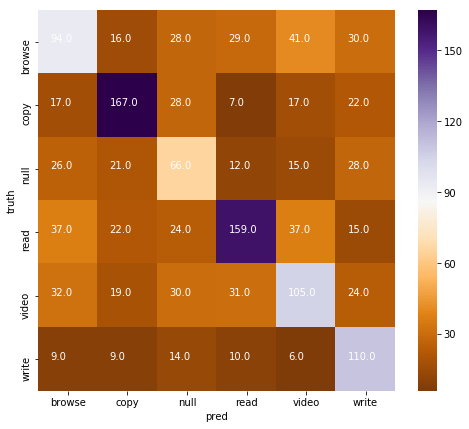

In [110]:
plt.figure(figsize = (8,7))
sns.heatmap(confusion_mat,cmap ='PuOr')
ax=plt.gca()
plt.xlabel('pred')
plt.ylabel('truth')
plt.xticks(np.arange(6)+0.5,ticks)
plt.yticks(np.arange(6)+0.5,ticks)

rendervalue(ax,6)   

In [112]:
BATCH_SIZE = 32

history =    model.fit(X_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=15,
              validation_data=(X_test, y_test))

Train on 12208 samples, validate on 1357 samples
Epoch 1/15
12208/12208 [==============================] - 126s 10ms/step - loss: 0.9043 - acc: 0.6587 - val_loss: 1.1271 - val_acc: 0.5822
Epoch 2/15
12208/12208 [==============================] - 126s 10ms/step - loss: 0.8947 - acc: 0.6613 - val_loss: 1.1170 - val_acc: 0.5954
Epoch 3/15
12208/12208 [==============================] - 126s 10ms/step - loss: 0.8889 - acc: 0.6636 - val_loss: 1.0755 - val_acc: 0.5895
Epoch 4/15
12208/12208 [==============================] - 126s 10ms/step - loss: 0.8557 - acc: 0.6728 - val_loss: 1.1173 - val_acc: 0.5814
Epoch 5/15
12208/12208 [==============================] - 126s 10ms/step - loss: 0.8426 - acc: 0.6815 - val_loss: 1.1104 - val_acc: 0.5785
Epoch 6/15
 3904/12208 [========>.....................] - ETA: 1:22 - loss: 0.8048 - acc: 0.6967

KeyboardInterrupt: 

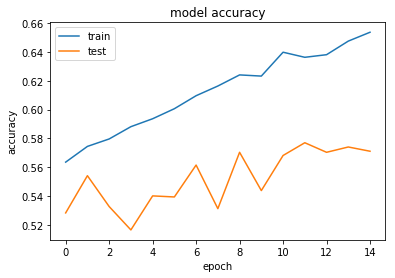

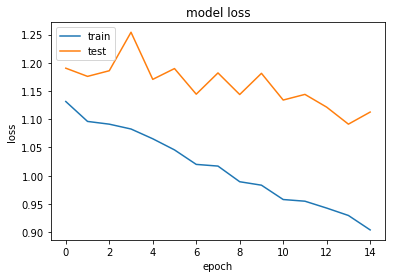

In [113]:
#history # summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

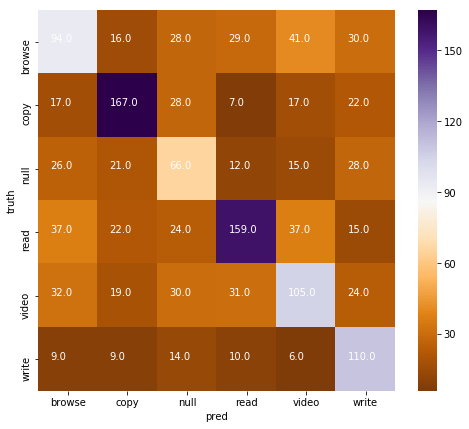

In [114]:
from keras.models import load_model
model.save('CCmCCmLLd50epochs.h5') 

preds = np.argmax(model.predict(X_test),axis = 1)
plt.figure(figsize = (8,7))
sns.heatmap(confusion_mat,cmap ='PuOr')
ax=plt.gca()
plt.xlabel('pred')
plt.ylabel('truth')
plt.xticks(np.arange(6)+0.5,ticks)
plt.yticks(np.arange(6)+0.5,ticks)

rendervalue(ax,6)   

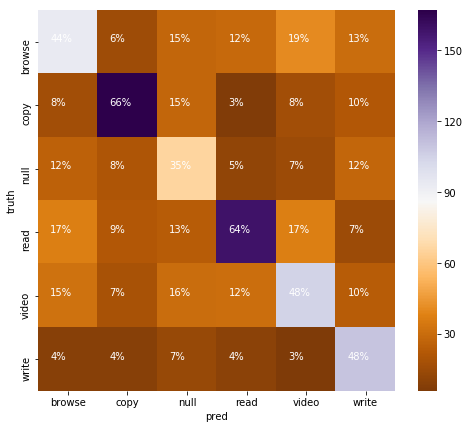

In [131]:
from sklearn.preprocessing import normalize
data = normalize(confusion_mat, axis=0,norm='l1')

plt.figure(figsize = (8,7))
sns.heatmap(confusion_mat,cmap ='PuOr')
ax=plt.gca()
plt.xlabel('pred')
plt.ylabel('truth')
plt.xticks(np.arange(6)+0.5,ticks)
plt.yticks(np.arange(6)+0.5,ticks)
def rendervalue(ax,conf_mat):
    for i in range(len(conf_mat)):  # the row index 
        for j in range(len(conf_mat[0])): # the column index, x1 
            ax.annotate("{0:0.0f}%".format(conf_mat[j,i]*100),(i+0.2,j+0.5),color='w')
rendervalue(ax,data)   

-------------------
draft

In [0]:
# LSTM model
model=Sequential()
# encode
model.add(LSTM(32,input_shape=(DURATION+1,1), return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(len(activities),activation='softmax'))
# model.add(TimeDistributed(Dense(len(activities),activation='softmax')))
# distributing the identical dense layer to the RNNs

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

In [0]:
BATCH_SIZE = 32

history =    model.fit(X_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=15,
              validation_data=(X_test, y_test))

In [0]:
# this model is prone to severe ovefitting

In [0]:
# we need larger dataset, here we choose detection duriation 1000 = 1s, using all people's data
, 

In [0]:
# def one_file_chopping(filenm, name,activity ,dirr="/mnt/c/Users/xzz/Documents/BDsync/Nataliya/dataAn/",
#                       select='A1', duration=5000):
#     with open(dirr+filenm) as f:
#         buffer = f.readlines()

#     for i,line in enumerate(buffer):
#         if  '# EndOfHeader\n' in line:
#             break
# #     header = buffer[:i+1]
#     data = buffer[i+1:]
#     dataset = []
#     for line in data:
#         linedata = [ int(x) for x in line.split('\t')[:-1] ]
#         dataset.append(linedata)
    
#     df = pd.DataFrame(dataset,columns=["nSeq", "I1", "I2", "O1", "O2", "A1", "A4"])
#     df = df[select]
#     lenn = len(df)
#     # get [0.1,0.99] data
#     start = lenn//10
#     new_chunk =[]
#     while start + duration  < lenn:
#         data_1 = df.iloc[start:start + duration ]
#         data_1 = scale(data_1)
#         new_chunk.append([data_1, name,activity ])
# #         print(start,name) ## test
# #         plt.figure(figsize=(18,3))
# #         plt.plot(data_1)
# #         plt.show()
#         start += duration
#     return new_chunk

# df

In [0]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(
#     df.seq.values, pd.get_dummies(df.activity) , test_size=0.3, random_state=0 ,stratify = pd.get_dummies(df.activity) )

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X1, pd.get_dummies(df.activity) , test_size=0.5, random_state=0 ,stratify = pd.get_dummies(df.activity) )

In [0]:
X_train[0]

In [0]:
N_filters=32
# CNN+LSTM model
model=Sequential()
# encode
model.add(Conv1D(filters = N_filters,kernel_size=10,strides=5,input_shape=(DURATION+1,1)))
model.add(Conv1D(filters = N_filters,kernel_size=3))
model.add(MaxPooling1D(pool_size = 3))
model.add(LSTM(32,input_shape=(DURATION+1,N_filters), return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(len(activities),activation='softmax'))
# model.add(TimeDistributed(Dense(len(activities),activation='softmax')))
# distributing the identical dense layer to the RNNs

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

In [0]:
BATCH_SIZE = 32

history =    model.fit(X_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=50,
              validation_data=(X_test, y_test))

Train on 354 samples, validate on 354 samples
Epoch 1/50
354/354 [==============================] - 26s 74ms/step - loss: 1.7661 - acc: 0.1864 - val_loss: 1.7195 - val_acc: 0.2034
Epoch 2/50
354/354 [==============================] - 23s 64ms/step - loss: 1.6524 - acc: 0.2938 - val_loss: 1.5016 - val_acc: 0.3842
Epoch 3/50
354/354 [==============================] - 23s 64ms/step - loss: 1.4175 - acc: 0.3616 - val_loss: 1.4774 - val_acc: 0.3531
Epoch 4/50
354/354 [==============================] - 23s 65ms/step - loss: 1.3836 - acc: 0.3588 - val_loss: 1.3665 - val_acc: 0.3588
Epoch 5/50
354/354 [==============================] - 23s 65ms/step - loss: 1.3567 - acc: 0.3842 - val_loss: 1.3511 - val_acc: 0.3729
Epoch 6/50
354/354 [==============================] - 23s 64ms/step - loss: 1.3470 - acc: 0.4435 - val_loss: 1.3471 - val_acc: 0.3842
Epoch 7/50
352/354 [============================>.] - ETA: 0s - loss: 1.3130 - acc: 0.4205

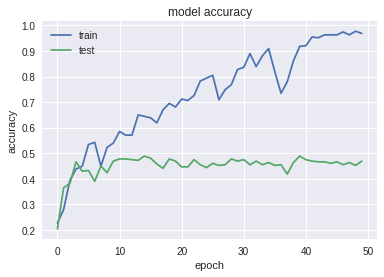

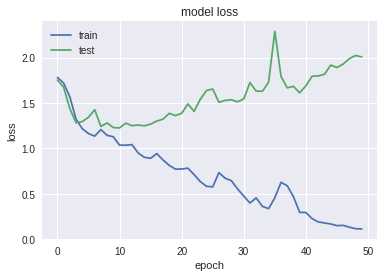

In [0]:
#history # summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

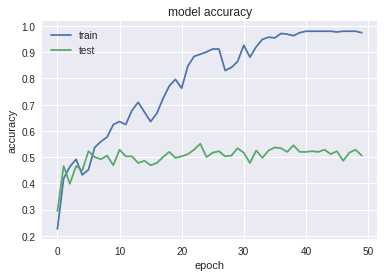

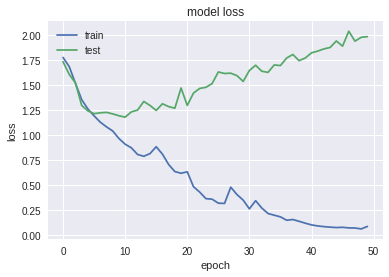

In [0]:
#history # summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()